In [217]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


In [218]:
# Load the dataset
df = pd.read_csv("country_data.csv")
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [219]:
df.shape

(167, 10)

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [221]:
df.duplicated().sum()

np.int64(0)

In [222]:
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

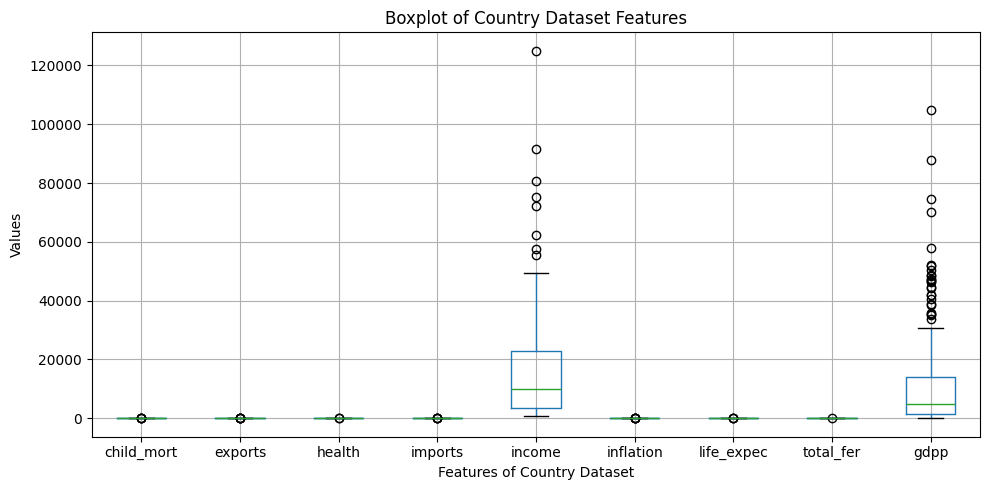

In [223]:
# Boxplot of the dataset to spot outliers
df.boxplot(figsize=(10,5))

# Add title and labels
plt.title('Boxplot of Country Dataset Features')
plt.xlabel('Features of Country Dataset')
plt.ylabel('Values')

plt.tight_layout()
plt.show()

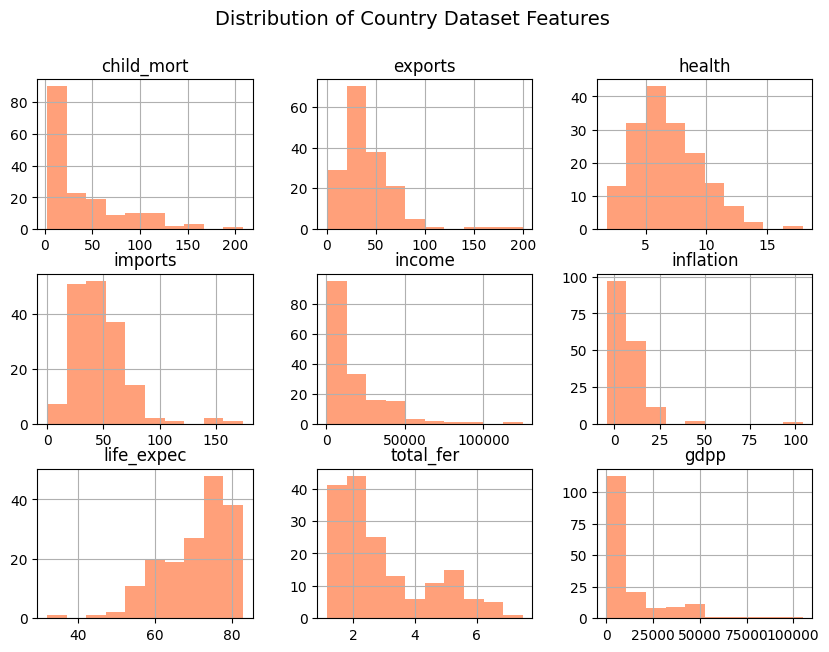

In [224]:
# Histogram of the dataset
df.hist(bins=10, color='#FFA07A', figsize=(10,7))

# Add title
plt.suptitle('Distribution of Country Dataset Features', fontsize=14)

plt.show()

In [225]:
# Feature clipping right skewed features
# Define list of right skewed featutres
features = ['gdpp', 'income', 'child_mort', 'exports', 'imports', 'inflation']

# Feature clip
for feature in features:
    lower_limit, upper_limit = np.percentile(df[feature], [1,95])
    df[feature] = np.clip(df[feature], lower_limit, upper_limit)

# Feature clipping left skewed features
lower_limit, upper_limit = np.percentile(df['life_expec'], [5,100])
df['life_expec'] = np.clip(df['life_expec'], lower_limit, upper_limit)

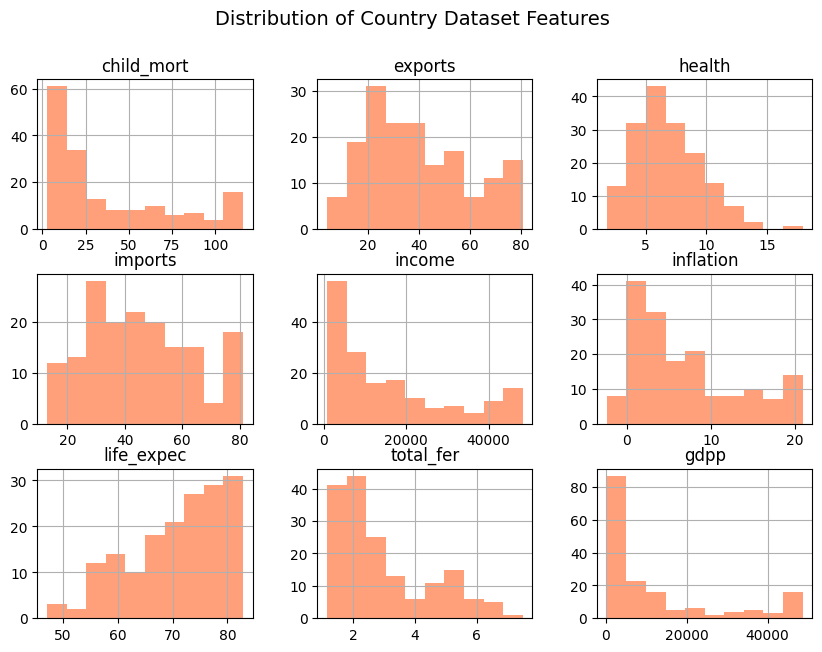

In [226]:
# Histogram of the dataset
df.hist(bins=10, color='#FFA07A', figsize=(10,7))

# Add title
plt.suptitle('Distribution of Country Dataset Features', fontsize=14)

plt.show()

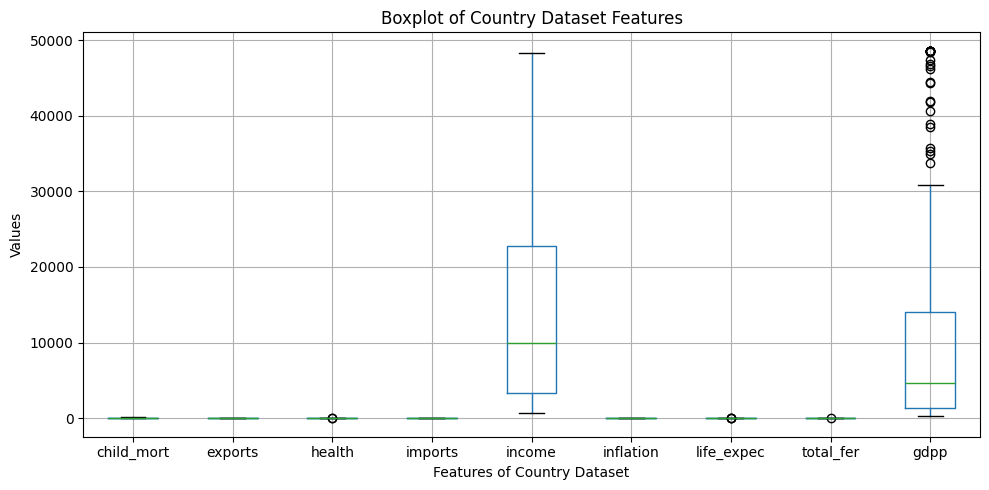

In [227]:
# Boxplot of the dataset to spot outliers
df.boxplot(figsize=(10,5))

# Add title and labels
plt.title('Boxplot of Country Dataset Features')
plt.xlabel('Features of Country Dataset')
plt.ylabel('Values')

plt.tight_layout()
plt.show()

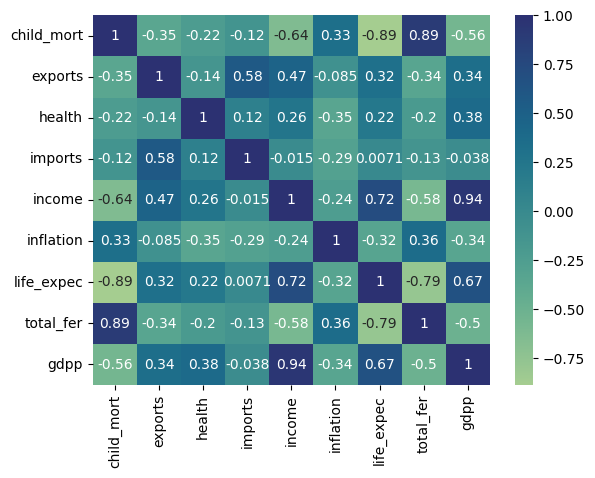

In [228]:
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='crest')
plt.show()

In [229]:
# Scale the features
features = df[['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [230]:
# Finding the k value
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(scaled_features)
    sse.append(km.inertia_)

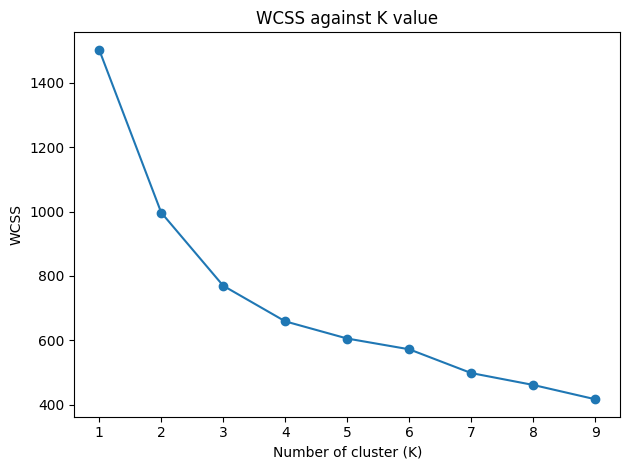

In [231]:
# plot
plt.plot(k_rng, sse, marker='o')
plt.xlabel('Number of cluster (K)')
plt.ylabel('WCSS')
plt.title('WCSS against K value')
plt.tight_layout()
plt.show()

In [232]:
## dimensionality reduction
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(scaled_features)

In [233]:
# Use the cluster to be 3
km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(reduced_data)
y_predicted

array([1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 1, 2, 2, 0, 2,
       2, 0, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 2, 0, 1, 0, 0, 0,
       0, 2, 2, 2, 2, 2, 1, 0, 2, 0, 0, 2, 1, 2, 0, 1, 0, 2, 2, 1, 1, 2,
       1, 0, 0, 1, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 1, 1, 0, 2, 1, 0, 0, 1,
       1, 2, 0, 0, 2, 1, 1, 2, 2, 1, 0, 1, 2, 1, 2, 2, 0, 2, 1, 1, 2, 1,
       0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 0, 0, 0, 2, 2, 1, 2, 2, 1, 0, 2,
       1, 0, 0, 0, 2, 1, 0, 0, 2, 2, 1, 2, 0, 0, 1, 1, 2, 1, 1, 2, 2, 2,
       2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1], dtype=int32)

In [234]:
# put the cluster into the dataframe
df['Cluster'] = y_predicted

df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553.0,1
1,Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090.0,2
2,Algeria,27.3,38.4,4.17,31.4,12900.0,16.10,76.5,2.89,4460.0,2
3,Angola,116.0,62.3,2.85,42.9,5900.0,20.87,60.1,6.16,3530.0,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100.0,1.44,76.8,2.13,12200.0,2
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950.0,2.62,63.0,3.50,2970.0,2
163,Venezuela,17.1,28.5,4.91,17.6,16500.0,20.87,75.4,2.47,13500.0,2
164,Vietnam,23.3,72.0,6.84,80.2,4490.0,12.10,73.1,1.95,1310.0,2
165,Yemen,56.3,30.0,5.18,34.4,4480.0,20.87,67.5,4.67,1310.0,1


In [235]:
# centroid
km.cluster_centers_

array([[ 2.51676316, -0.23643344,  0.24925437],
       [-2.6004759 , -0.17542948,  0.42468502],
       [-0.05138199,  0.27298603, -0.44095799]])

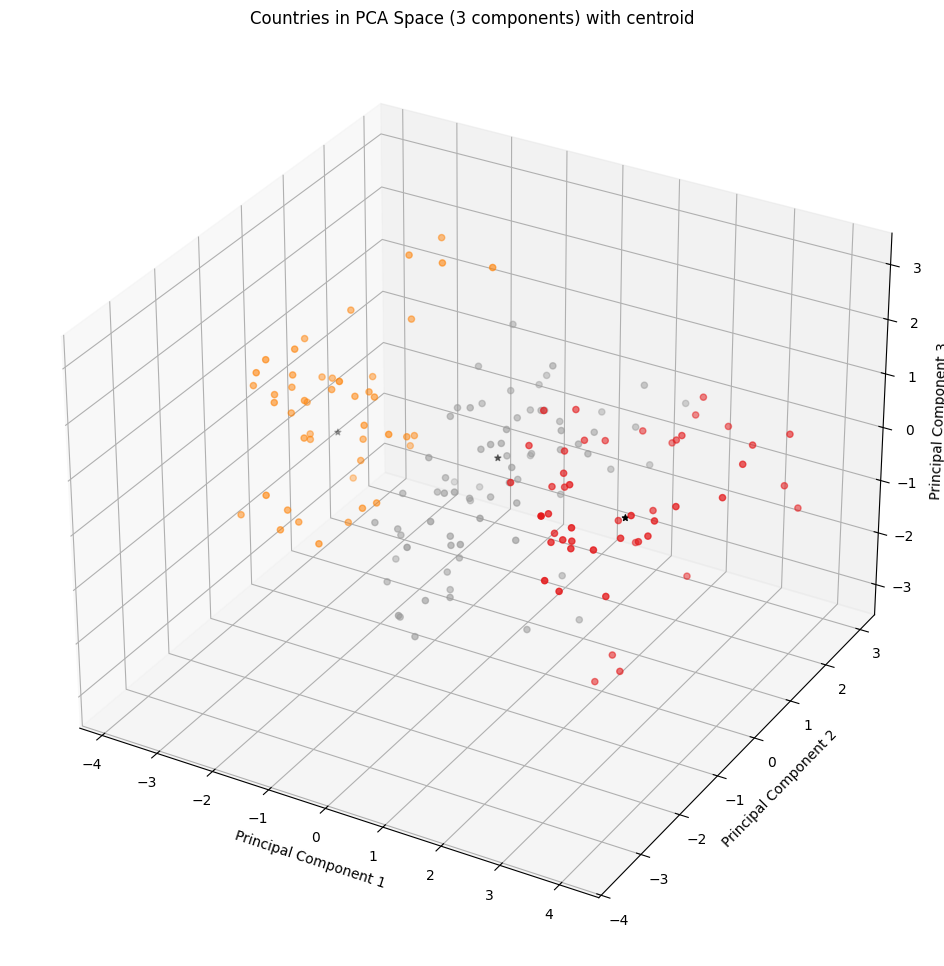

In [236]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot in 3D
scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=df["Cluster"], cmap="Set1")
scatter = ax.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], color = 'black', marker='*', label = 'centroid')

# Add title and labels
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.title("Countries in PCA Space (3 components) with centroid")

plt.show()

In [237]:
# Statistics summary per cluster
numeric_cols = df.select_dtypes(include="number").columns
cluster_summary = df.groupby("Cluster")[numeric_cols].agg(["mean", "median", "min", "max"])
print(cluster_summary)

        child_mort                        exports                         \
              mean median   min    max       mean median      min    max   
Cluster                                                                    
0         5.834694   4.60   2.8   14.2  49.007143   46.2  12.4000  80.57   
1        86.952174  89.75  40.0  116.0  23.628452   22.4   3.9094  62.30   
2        25.800000  19.75   5.5  111.0  42.266389   40.5  10.7000  80.57   

           health         ... total_fer                gdpp                    \
             mean median  ...       min   max          mean   median      min   
Cluster                   ...                                                   
0        8.648571  9.110  ...      1.15  3.03  31090.816327  33700.0  4610.00   
1        6.473478  5.480  ...      2.41  7.49   1138.157391    748.0   331.62   
2        5.786944  5.605  ...      1.27  5.21   5945.888889   4550.0   758.00   

                 Cluster                 
             m

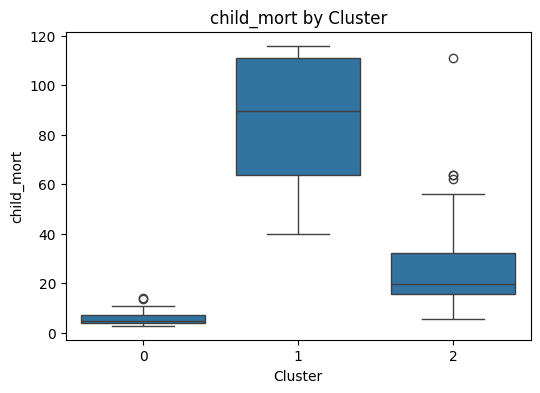

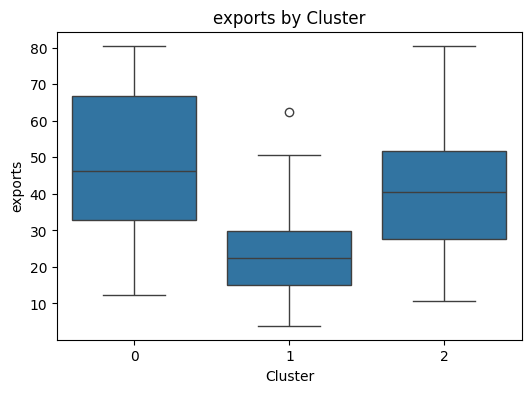

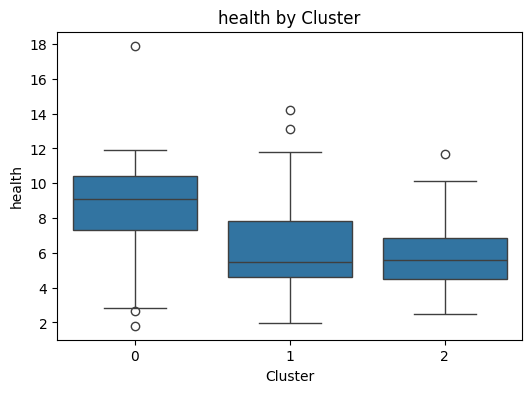

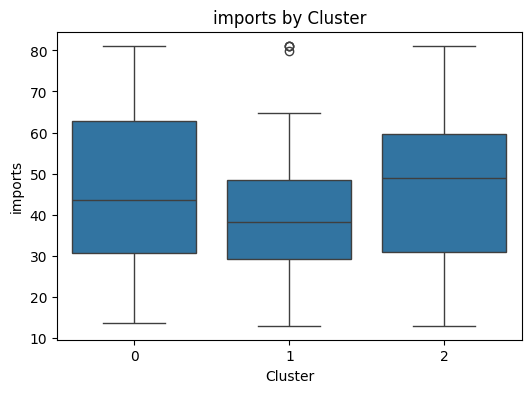

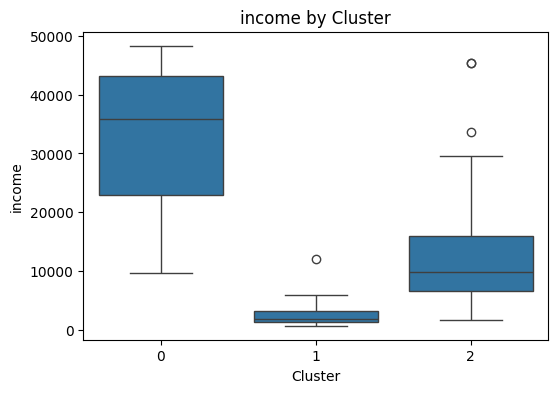

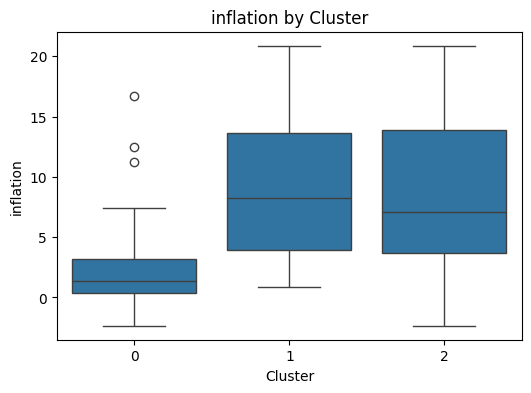

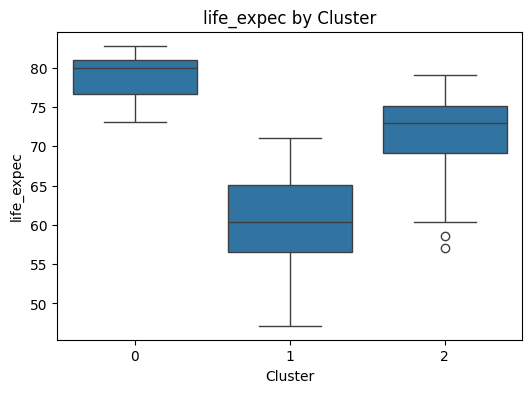

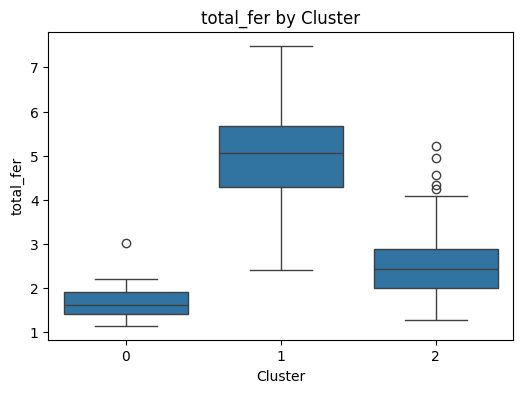

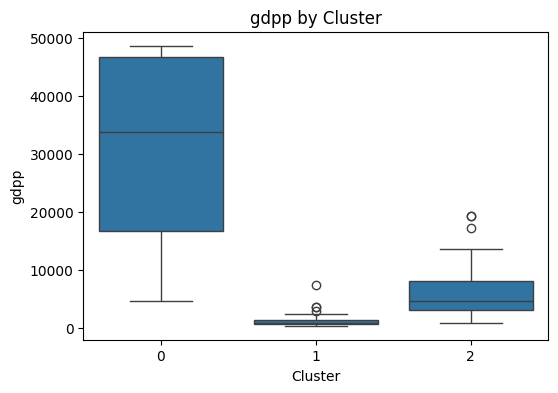

In [238]:
# Check the distribution of each Feature by cluster
features = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
for feat in features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Cluster", y=feat, data=df)
    plt.title(f"{feat} by Cluster")
    plt.show()

In [239]:
# Compare means side by side

# Extract means of each cluster
mean_values = df.groupby("Cluster")[['child_mort', 'exports', 'health', 'imports', 'inflation', 'life_expec', 'total_fer']].mean()
print(mean_values)
# Transpose - rows: features, columns = cluster
mean_value_transposed = mean_values.T
print(mean_value_transposed)


         child_mort    exports    health    imports  inflation  life_expec  \
Cluster                                                                      
0          5.834694  49.007143  8.648571  47.325714   2.464718   79.032653   
1         86.952174  23.628452  6.473478  41.203652   9.305326   60.146087   
2         25.800000  42.266389  5.786944  46.384833   8.487669   71.655556   

         total_fer  
Cluster             
0         1.704898  
1         4.884565  
2         2.556667  
Cluster             0          1          2
child_mort   5.834694  86.952174  25.800000
exports     49.007143  23.628452  42.266389
health       8.648571   6.473478   5.786944
imports     47.325714  41.203652  46.384833
inflation    2.464718   9.305326   8.487669
life_expec  79.032653  60.146087  71.655556
total_fer    1.704898   4.884565   2.556667


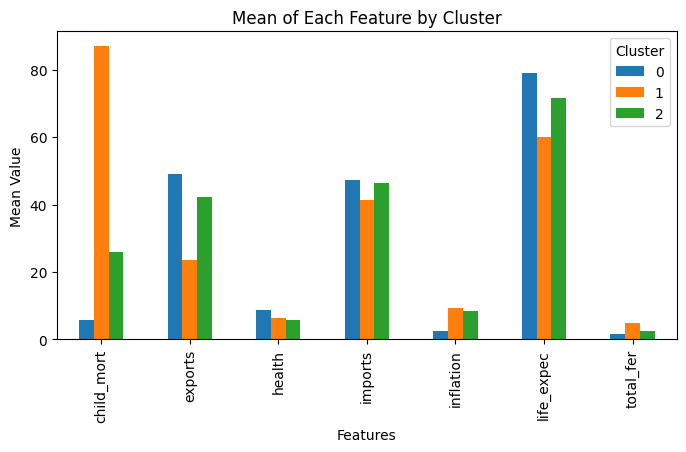

In [240]:
# plot tranposed 
mean_value_transposed.plot.bar(figsize=(8,4))
plt.title("Mean of Each Feature by Cluster")
plt.xlabel("Features")
plt.ylabel("Mean Value")
plt.show()